T4 - хорошо

K80 - плохо

In [1]:
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-04d6baaa-9114-7a22-be28-6ba79a77adbd)


Куча импортов

In [2]:
!pip install albumentations

In [3]:
import numpy as np
import pandas as pd
import shutil
import os
import random
import zipfile
import torch
import torch.nn as nn
import csv
import cv2
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms
import torch.nn.functional as F
import copy
import tqdm
import time
from PIL import Image

import albumentations
from albumentations import pytorch as AT

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
with zipfile.ZipFile('/content/drive/MyDrive/sportsDataset.zip', 'r') as zip_ref:
  zip_ref.extractall('/content')
  
with zipfile.ZipFile('/content/train.zip', 'r') as zip_ref:
  zip_ref.extractall('/content/train')

with zipfile.ZipFile('/content/test.zip', 'r') as zip_ref:
  zip_ref.extractall('/content/test')

with zipfile.ZipFile('/content/valid.zip', 'r') as zip_ref:
  zip_ref.extractall('/content/valid')

Функции, котрые мне пригодятся позже:



In [6]:
def SeedEverything(seed): # задаём сид
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

SeedEverything(41)

In [7]:
def FindLabel(fileName): # на вход получает название файла и ищет его лейбл по csv файлу
    with open("train_labels.csv", encoding='utf-8') as inputFile:
        inputReader = csv.reader(inputFile, delimiter=",")
        for row in inputReader:
            if row[0] == "image":  # скипаем первую строчку
                continue
            csvFileName = row[0].replace("./train/", "")
            if csvFileName == fileName:
                return row[1]
    return 0

In [8]:
def GetCategoryList(): # возвращет полный список всех возможных лейблов
    labelList = []

    with open("train_labels.csv", encoding='utf-8') as inputFile:
        inputReader = csv.reader(inputFile, delimiter=",")
        for row in inputReader:
            if row[0] == "image":  # скипаем первую строчку
                continue
            if labelList.count(row[1]) == 0:
                labelList.append(row[1])

    return labelList

testList = GetCategoryList()

print(f'{len(testList)} уникальных категорий')
print(testList)

22 уникальных категорий
['baseball', 'formula1', 'fencing', 'motogp', 'ice_hockey', 'wrestling', 'boxing', 'volleyball', 'cricket', 'basketball', 'wwe', 'swimming', 'weight_lifting', 'gymnastics', 'tennis', 'kabaddi', 'badminton', 'football', 'table_tennis', 'hockey', 'shooting', 'chess']


In [9]:
train_dir = '/content/train'
test_dir = '/content/test'
valid_dir = '/content/valid'

# получим список файлов в папках
train_files = os.listdir(train_dir)
test_files = os.listdir(test_dir)
valid_files = os.listdir(valid_dir)

print(len(train_files)) #7750
print(len(test_files)) #1645
print(len(valid_files)) #1645

7750
1645
1645


In [10]:
class SportsDataset(Dataset):
    def __init__(self, file_list, dir, transform=None):
        self.file_list = file_list
        self.dir = dir
        self.transform = transform
        self.labelList = GetCategoryList()

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        image = cv2.imread(os.path.join(self.dir, self.file_list[idx])) # считываем изображение       
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # делаем изображение RGB        
        self.label = self.labelList.index(FindLabel(self.file_list[idx])) # далее нужно присвоить лейбл каждой картинке

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        return image, int(self.label)

In [11]:
batch_size = 54
num_workers = 0
img_size = 256

In [12]:
data_transforms = albumentations.Compose([
    albumentations.Resize(img_size, img_size),
    albumentations.HorizontalFlip(p=0.5),
    albumentations.RandomBrightness(),
    albumentations.ShiftScaleRotate(rotate_limit=15, scale_limit=0.10),
    albumentations.HueSaturationValue(),
    albumentations.Normalize(),
    AT.ToTensor()
])

data_transforms_test = albumentations.Compose([
    albumentations.Resize(img_size, img_size),
    albumentations.HorizontalFlip(),
    albumentations.RandomRotate90(),
    albumentations.Normalize(),
    AT.ToTensor()
])

In [13]:
train_set = SportsDataset(train_files, train_dir, transform=data_transforms)
test_set = SportsDataset(test_files, test_dir, transform=data_transforms_test)
valid_set = SportsDataset(valid_files, valid_dir, transform=data_transforms_test)

print(len(train_set), len(valid_set))

7750 1645


In [14]:
trainloader = torch.utils.data.DataLoader(train_set, pin_memory=True,
                                        batch_size=batch_size, shuffle=True,
                                        num_workers=num_workers)
validloader = torch.utils.data.DataLoader(valid_set, pin_memory=True,
                                        batch_size=batch_size, shuffle=True)

testloader = torch.utils.data.DataLoader(test_set, batch_size = 1, #берем картинки по одной
                                         num_workers = num_workers, shuffle=False)

Вывод изображений для проверки, что все нормально загрузилось

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([18,  8,  4, 14,  2, 18, 20,  3, 16,  8,  2,  2, 12,  3, 11, 16, 20,  1,
         6, 16,  6, 17,  7, 21, 10,  0, 17, 14, 13, 15,  5, 19,  4,  1,  9, 15,
        14,  9, 11,  0, 20, 13,  3, 15,  1, 17,  3,  6, 20, 14, 12,  6, 13,  4])


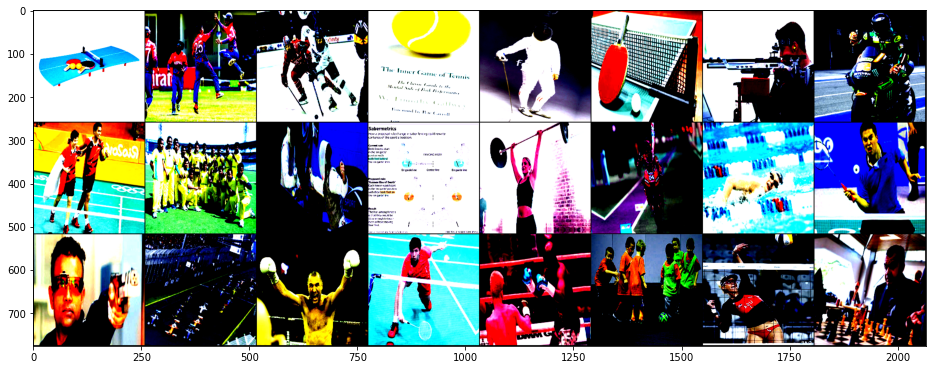

In [15]:
samples, labels = next(iter(trainloader))
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(samples[:24])
np_grid_imgs = grid_imgs.numpy()
print(labels)
plt.imshow(np.transpose(np_grid_imgs, (1,2,0)))

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [17]:
model = torchvision.models.resnet152(pretrained=True, progress=True)
for param in model.parameters():
    param.requires_grad = False
model.fc = nn.Linear(2048, 1024)
model.fc1 = nn.Linear(1024, 512)
model.fc2 = nn.Linear(512, 22)

lr = 0.1
n_epoch = 10

model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=lr,)

criterion = nn.CrossEntropyLoss()
sheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=0, factor= 0.5)

In [18]:
def train_model(model, train_loader, valid_loader, criterion, optimizer,  n_epochs):
    model.train()
    model.to(device)
    valid_loss_min = np.Inf
    patience = 5
    p = 0
    stop = False

    #train
    for epoch in range(1, n_epochs+1):
        print(time.ctime(), 'Epoch:', epoch)

        train_loss = []

        for batch_i, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            train_loss.append(loss.item())
            loss.backward()
            optimizer.step()

      #val
        model.eval()
        val_loss = []
        for batch_i, (data, target) in enumerate(valid_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            val_loss.append(loss.item()) 

        print(f'Epoch {epoch}, train loss: {np.mean(train_loss):.4f}, valid loss: {np.mean(val_loss):.4f}.')
        #получаем лосс валидации и справниваем его с минимальным лоссом

        valid_loss = np.mean(val_loss)
        sheduler.step(valid_loss)
        # если лосс стал меньше, то сохраняем чекпоинт а терпение сбрасываем (можно и не сбрасывать)
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), 'model.pt')
            valid_loss_min = valid_loss
            p = 0

        # если лосс стал больше, то терпение нарастает
        if valid_loss > valid_loss_min:
            p += 1
            print(f'{p} epochs of increasing val loss')
            if p > patience:
                print('Stopping training')
                stop = True
                break        

        if stop:
            break
    return model, train_loss, val_loss

train_model(model, trainloader, validloader, criterion, optimizer, n_epochs = 10)

Tue Apr 27 14:29:43 2021 Epoch: 1


KeyboardInterrupt: ignored

In [27]:
model.load_state_dict(torch.load("model.pt"))

<All keys matched successfully>

Здесь я считаю точность

In [29]:
model.eval()
correct = 0

with torch.no_grad():
  for data, target in testloader:
    data = data.to(device=device)
    target = target.to(device=device)
    outputs = model(data)
    _, predicted = torch.max(outputs.data, 1)
    correct += (predicted == target).sum().item()


acc = correct / len(test_set)
print(f'Accuracy on test set: {acc}')

Accuracy on test set: 0.8018237082066869


А здесь пробная раняя версия вывода результатов, в последствии доработана и не используется для обучения

In [ ]:
model.eval()
f = open("output.csv", "w")
with torch.no_grad():
    for i, (image, label) in enumerate(testloader, 0):
      image = image.to(device=device)
      label = label.to(device=device)
      output = model(image)
      _, predicted = torch.max(output.data, 1)
      sample_fname = testloader.dataset.file_list[i]
      print(sample_fname, '\t', predicted.item())
      
f.close()

                                        









---

